# LeNet

## 模型简介
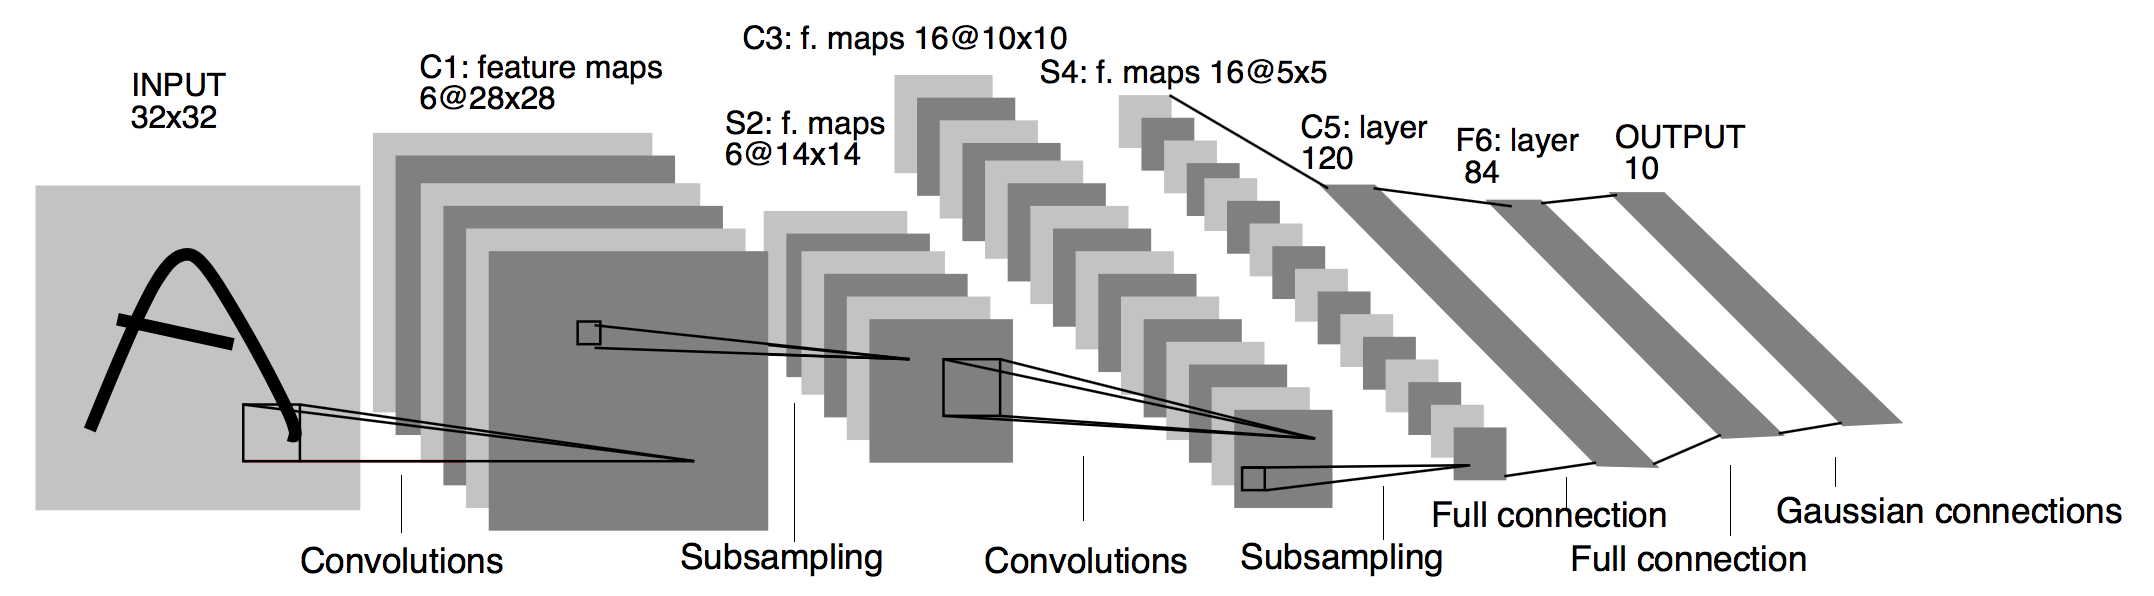

<center>网络结构图

LeNet分为卷积层块和全连接层块两个部分。

- 卷积层块里的基本单位是卷积层后接最大池化层：卷积层用来识别图像里的空间模式，如线条和物体局部，之后的最大池化层则用来降低卷积层对位置的敏感性。卷积层块由两个这样的基本单位重复堆叠构成。在卷积层块中，每个卷积层都使用5×55×5的窗口，并在输出上使用sigmoid激活函数。第一个卷积层输出通道数为6，第二个卷积层输出通道数则增加到16。这是因为第二个卷积层比第一个卷积层的输入的高和宽要小，所以增加输出通道使两个卷积层的参数尺寸类似。卷积层块的两个最大池化层的窗口形状均为2×22×2，且步幅为2。由于池化窗口与步幅形状相同，池化窗口在输入上每次滑动所覆盖的区域互不重叠。

- 卷积层块的输出形状为(批量大小, 通道, 高, 宽)。当卷积层块的输出传入全连接层块时，全连接层块会将小批量中每个样本变平（flatten）。也就是说，全连接层的输入形状将变成二维，其中第一维是小批量中的样本，第二维是每个样本变平后的向量表示，且向量长度为通道、高和宽的乘积。全连接层块含3个全连接层。它们的输出个数分别是120、84和10，其中10为输出的类别个数。

## 通过Sequential类构建LeNet

In [3]:
import time
import torch
from torch import nn, optim

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5), # in_channels, out_channels, kernel_size
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Conv2d(6, 16, 5),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output


**查看网络结构**

In [4]:
net = LeNet()
print(net)

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


## 使用模型
下面我们来实验LeNet模型。实验中，我们仍然使用Fashion-MNIST作为训练数据集。

（1）导入数据

In [5]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=256)

100.0%

Extracting C:\Users\dell/Datasets/FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to C:\Users\dell/Datasets/FashionMNIST\FashionMNIST\raw


111.0%

Extracting C:\Users\dell/Datasets/FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\dell/Datasets/FashionMNIST\FashionMNIST\raw


100.0%

Extracting C:\Users\dell/Datasets/FashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\dell/Datasets/FashionMNIST\FashionMNIST\raw


159.1%..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting C:\Users\dell/Datasets/FashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\dell/Datasets/FashionMNIST\FashionMNIST\raw
Processing...
Done!


（2）定义准确率计算函数

In [6]:
# 计算正确率函数
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: 
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n


（3）训练函数

In [7]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    loss = torch.nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))


（4）定义超参数，开始训练

In [8]:
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 1.8975, train acc 0.291, test acc 0.569, time 25.7 sec
epoch 2, loss 0.9685, train acc 0.620, test acc 0.651, time 7.0 sec
epoch 3, loss 0.7815, train acc 0.709, test acc 0.716, time 6.9 sec
epoch 4, loss 0.6868, train acc 0.740, test acc 0.746, time 6.9 sec
epoch 5, loss 0.6327, train acc 0.753, test acc 0.757, time 6.9 sec
